In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.layers import Dense, Conv2D, Input, Flatten, Reshape, Conv2DTranspose, Dropout
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K


Using TensorFlow backend.


In [0]:
def preprocessing(data):

    X_tr = []
    #img = cv2.imread('scene.JPG')
    for i in range(data.shape[0]):

        img = data[i]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        inv = 255 - gray
        blur = cv2.GaussianBlur(inv, (15, 15), sigmaX=0)
        X_tr.append(cv2.divide(gray, 255 - blur, scale=256))

    return X_tr


In [0]:
lat_dim = 128
inp_dim = (32, 32, 1)
img_dim = 32
channels = 3

In [4]:
(X_train, _), (X_test, _) = cifar10.load_data()
X_train_sketch = preprocessing(X_train)
X_test_sketch = preprocessing(X_test)

170500096/170498071 [==============================] - 6s 0us/step


In [5]:
X_train_sketch = np.asarray(X_train_sketch)
X_test_sketch = np.asarray(X_test_sketch)

X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255
X_train_sketch = X_train_sketch.astype('float32')/255
X_test_sketch = X_test_sketch.astype('float32')/255
print(X_train.shape)
print(X_train_sketch.shape)

(50000, 32, 32, 3)
(50000, 32, 32)


In [6]:
X_train_sketch = X_train_sketch.reshape(X_train_sketch.shape[0], img_dim, img_dim, 1)
X_test_sketch = X_test_sketch.reshape(X_test_sketch.shape[0], img_dim, img_dim, 1)
print(X_train_sketch.shape)

(50000, 32, 32, 1)


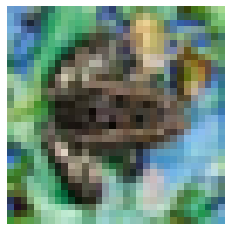

In [7]:
plt.imshow(X_train[200])
plt.axis('off')
plt.show()

In [8]:
#Encoder Model
inputs = Input(shape=inp_dim, name='Encoder_Input')
x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(inputs)
x = Conv2D(256, (3, 3), strides=2, padding='same', activation='relu')(x)
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
latent = Dense(lat_dim, activation='relu', name='Latent_Vector')(x)

encoder = Model(inputs, latent, name='Encoder_Model')
encoder.summary()




Model: "Encoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         147712    
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               8389120   
_________________________________________________________________
Latent_Vector (Dense)        (None, 128)               65664     
Total params: 8,603,136
Trainable params: 8,603,136
Non-trainable params: 0
________________________________________

In [9]:
# Decoder Model
lat_inp = Input(shape=(lat_dim,), name='Decoder_Input')
x = Dense(512, activation='relu')(lat_inp)
x = Dense(shape[1]*shape[2]*shape[3])(x)
x = Reshape((shape[1], shape[2], shape[3]), input_shape=(shape[1]*shape[2]*shape[3], ))(x)
x = Conv2DTranspose(256, (3, 3), strides=2, activation='relu', padding='same')(x)
x = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
output = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', name='Decoder_output')(x)

decoder = Model(lat_inp, output, name='Decoder_Model')
decoder.summary()

Model: "Decoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input (InputLayer)   (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             8404992   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       590080    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 64)        147520    
_________________________________________________________________
Decoder_output (Conv2DTransp (None, 32, 32, 3)       

In [10]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name='Autoencoder_Model')
autoencoder.summary()

Model: "Autoencoder_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_Input (InputLayer)   (None, 32, 32, 1)         0         
_________________________________________________________________
Encoder_Model (Model)        (None, 128)               8603136   
_________________________________________________________________
Decoder_Model (Model)        (None, 32, 32, 3)         9210371   
Total params: 17,813,507
Trainable params: 17,813,507
Non-trainable params: 0
_________________________________________________________________


In [11]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, verbose=1, min_lr=0.5e-6)
autoencoder.compile(loss='mse', optimizer='Adam', metrics=['accuracy'])

In [15]:
autoencoder.fit(X_train_sketch, X_train, validation_data=(X_test_sketch, X_test), epochs=30, batch_size=64)

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 19s 372us/step - loss: 0.0152 - acc: 0.5678 - val_loss: 0.0285 - val_acc: 0.5349
Epoch 2/30
50000/50000 [==============================] - 19s 375us/step - loss: 0.0149 - acc: 0.5684 - val_loss: 0.0291 - val_acc: 0.5151
Epoch 3/30
50000/50000 [==============================] - 18s 367us/step - loss: 0.0146 - acc: 0.5707 - val_loss: 0.0295 - val_acc: 0.5369
Epoch 4/30
50000/50000 [==============================] - 18s 369us/step - loss: 0.0144 - acc: 0.5717 - val_loss: 0.0293 - val_acc: 0.5366
Epoch 5/30
50000/50000 [==============================] - 18s 369us/step - loss: 0.0140 - acc: 0.5729 - val_loss: 0.0297 - val_acc: 0.5077
Epoch 6/30
50000/50000 [==============================] - 18s 370us/step - loss: 0.0139 - acc: 0.5744 - val_loss: 0.0293 - val_acc: 0.5386
Epoch 7/30
50000/50000 [==============================] - 18s 370us/step - loss: 0.0137 - acc: 0.5747 - val_loss: 0.

In [0]:
autoencoder.save('sketch_to_image_model.h5')
x_decoded = autoencoder.predict(X_test_sketch)

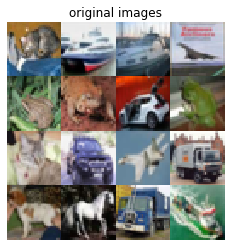

In [16]:
# display original sketch image
imgs = X_test[:16]
imgs = imgs.reshape((4, 4, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.imshow(imgs)
plt.title('original images')
plt.axis('off')
plt.show()

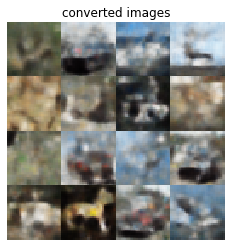

In [21]:
# display converted images
imgs = x_decoded[:16]
imgs = imgs.reshape((4, 4, img_dim, img_dim, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.imshow(imgs)
plt.title('converted images')
plt.axis('off')
plt.show()

In [22]:
from google.colab import files
files.download('sketch_to_image_model.h5')

MessageError: ignored